In [21]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from biopandas.pdb import PandasPdb
import seaborn as sns

In [85]:
closest_dist_filter = 1 # does not do anything different until you get below 0.05, so it seems all 7 that are filtered out by this are truly redudant 
# probably will actually need to do 2A to keep things discrete???

df = pd.read_csv('nt_wat_peaks.csv')
coords = df[['x', 'y', 'z']].values
# Compute the pairwise Euclidean distances between all points
dists = cdist(coords, coords, metric='euclidean')
# Set diagonal to infinity to ignore self-distance (distance to itself)
np.fill_diagonal(dists, np.inf)
# Find the minimum distance to any other point for each row
df['min_dist'] = dists.min(axis=1)


# unclear why segger has overlapping regions of different size, but not going to fix segger, so ust filter, choosing max dens
print(df[df.min_dist == df.min_dist.min()]) # an example
# Identify pairs where distance is less than closest_dist_filter
close_pairs = np.where(dists < closest_dist_filter)
# Loop over each close pair, keeping highest density
rows_to_keep = set(range(len(df)))
for i, j in zip(*close_pairs):
    if i != j:
        # Compare dens values and keep the row with the higher dens value
        if df.loc[i, 'dens'] < df.loc[j, 'dens']:
            rows_to_keep.discard(i)  
        else:
            rows_to_keep.discard(j) 
filtered_df = df.iloc[list(rows_to_keep)]
print(len(df)-len(filtered_df))
# need to recompute dists
coords = filtered_df[['x', 'y', 'z']].values
dists = cdist(coords, coords, metric='euclidean')
np.fill_diagonal(dists, np.inf)
filtered_df['min_dist'] = dists.min(axis=1)

               x           y          z       dens       sig  npts  min_dist
298   145.463570  126.055222  91.164121  35.574348  1.358098    12  0.000493
1291  145.464061  126.055259  91.164108  35.575691  1.358189    17  0.000493
61


/tmp/ipykernel_80716/3618187601.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['min_dist'] = dists.min(axis=1)


<Axes: xlabel='min_dist', ylabel='Count'>

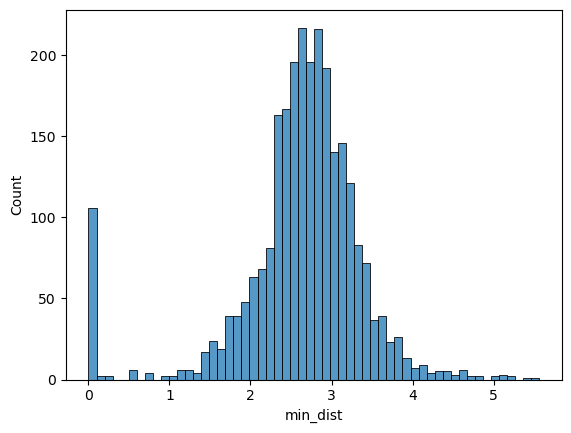

In [86]:
sns.histplot(df,x='min_dist')

<Axes: xlabel='min_dist', ylabel='Count'>

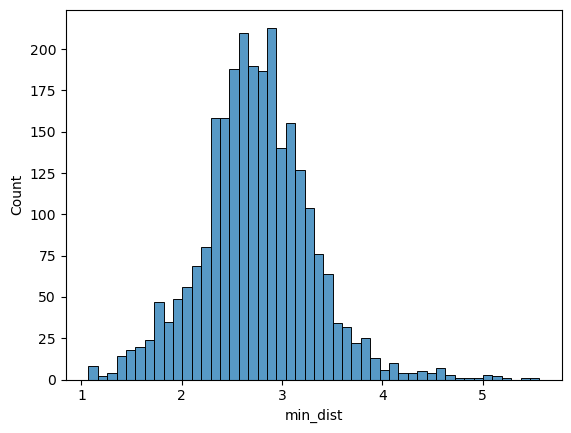

In [87]:
sns.histplot(filtered_df,x='min_dist')

In [100]:
# now check if all of 2.2 and 2.3 A are within a peak region
pdb22_f = '../models/2.2A_SWIM.pdb'
pdb23_f = '../models/23in22.pdb'

pdb22 = PandasPdb().read_pdb(pdb22_f)
pdb23 = PandasPdb().read_pdb(pdb23_f)

wat22 = pdb22.df['HETATM'][pdb22.df['HETATM'].residue_name=='HOH'].copy()
wat23 = pdb23.df['ATOM'][pdb23.df['ATOM'].atom_name=='HOH'].copy()
rna = pdb22.df['ATOM'].copy()

# rna_coord = pdb22.df['ATOM'][['x_coord', 'y_coord', 'z_coord']].values
coords22 = wat22[['x_coord', 'y_coord', 'z_coord']].values
coords23 = wat23[['x_coord', 'y_coord', 'z_coord']].values

dists = cdist(coords, coords22, metric='euclidean')
mindist22 = dists.min(axis=0) # min over cryoEM
dists = cdist(coords, coords23, metric='euclidean')
mindist23 = dists.min(axis=0) # min over cryoEM

wat22['min_dist'] = mindist22
wat23['min_dist'] = mindist23

49.80392156862745
84.70588235294117


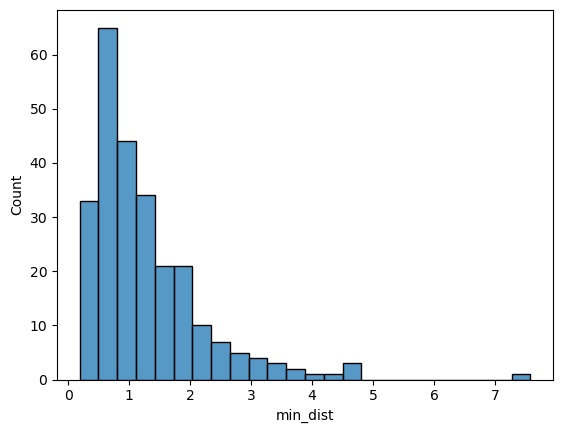

In [89]:
sns.histplot(wat22,x='min_dist')
print(100*(wat22.min_dist<1).mean())
print(100*(wat22.min_dist<2).mean())

52.66903914590747
85.40925266903915


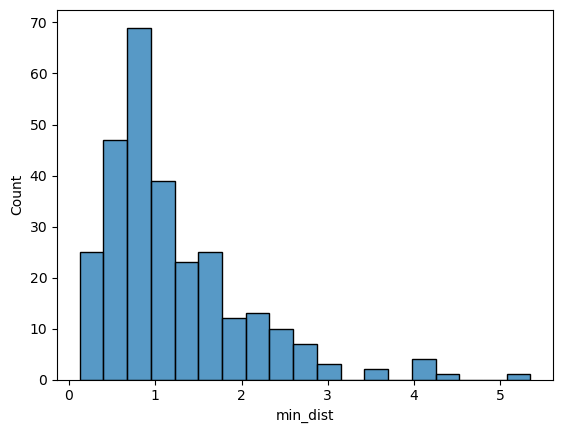

In [90]:
sns.histplot(wat23,x='min_dist')
print(100*(wat23.min_dist<1).mean())
print(100*(wat23.min_dist<2).mean())

In [159]:
# test bind site def
# 2.3

min_wat_dist = 3.4

def get_atom_list(df):
    nums, ats, new_atoms = [], [], []
    for i,row in df.iterrows():
        at = row.atom_name
        nuc = row.residue_name
        num = row.residue_number
        if at == "OP1" or at == "OP2":
            at = "OP"
        nums.append(int(num))
        ats.append(at)
        new_atoms.append(nuc+"-"+str(num)+":"+at)
    new_atoms = [x for _, __, x in sorted(zip(nums, ats, new_atoms),key=lambda pair: (pair[0],pair[1]))]
    return " ".join(new_atoms)

def get_bound_rna_atoms(compare, rna=rna,min_wat_dist=min_wat_dist):
    dists = cdist(compare, rna[['x_coord', 'y_coord', 'z_coord']], metric='euclidean')
    atoms = []
    for i in range(len(compare)):
        indices = np.where(dists[i] <= min_wat_dist)[0]
        atoms.append(get_atom_list(rna.iloc[indices]))
    return atoms

def get_atom_name_list(atom_string):
    atoms = atom_string.split()
    atoms = [x.split(':')[-1] for x in atoms]
    return atoms

#get_bound_rna_atoms(coords)
# filter any not in criteria 


def get_pass_swim_geom(coords):
    # 3.2 from C or P
    clash_C_P = []
    for at in get_bound_rna_atoms(coords,min_wat_dist=3.2):
        names = get_atom_name_list(at)
        #print(names, [s[0] in ["C","P"] for s in names])
        
        clash_C_P.append( any(s[0] in ["C","P"] for s in names))
    
    # 3.4 from a N or O
    bind_polar = []
    for at in get_bound_rna_atoms(coords,min_wat_dist=3.4):
        names = get_atom_name_list(at)
        bind_polar.append( any(s[0] in ["O","N"] for s in names))

    clash_C_P = np.array(clash_C_P)
    bind_polar = np.array(bind_polar)
    return bind_polar & ~clash_C_P

print(get_pass_swim_geom(coords22).mean())
print(get_pass_swim_geom(coords23).mean()) # ok not to be 1 because this is aligned 2.2 A so may be some slight offs
coords_pass_geom = coords[get_pass_swim_geom(coords)]
print(len(coords_pass_geom),len(coords),len(coords_pass_geom)/len(coords))

1.0
0.9537366548042705
1421 2576 0.5516304347826086


In [160]:
# now check if all of 2.2 and 2.3 A are within a peak region with geom ok
dists = cdist(coords_pass_geom, coords22, metric='euclidean')
mindist22 = dists.min(axis=0) # min over cryoEM
dists = cdist(coords_pass_geom, coords23, metric='euclidean')
mindist23 = dists.min(axis=0) # min over cryoEM

wat22['min_dist_geom_ok'] = mindist22
wat23['min_dist_geom_ok'] = mindist23

52.66903914590747
85.40925266903915


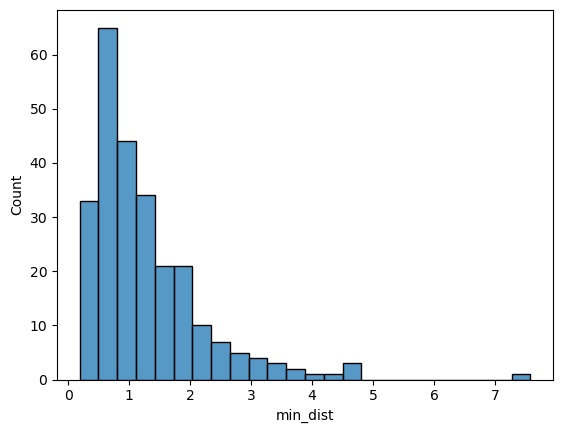

In [161]:
sns.histplot(wat22,x='min_dist')
print(100*(wat23.min_dist<1).mean())
print(100*(wat23.min_dist<2).mean())

52.66903914590747
85.40925266903915


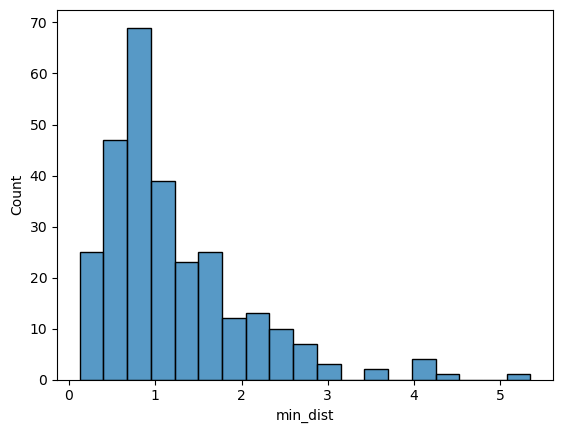

In [162]:
sns.histplot(wat23,x='min_dist')
print(100*(wat23.min_dist<1).mean())
print(100*(wat23.min_dist<2).mean())

In [ ]:
# filtering seems like a fair way to define the no cryoEM sites.

In [163]:
# check binding site similiarites

wat22_rna = get_bound_rna_atoms(coords22)
wat23_rna = get_bound_rna_atoms(coords23)
md_rna = get_bound_rna_atoms(coords_pass_geom)

In [171]:
# will need the close logic ... careful with the distances!!!
sum([x in md_rna for x in wat22_rna])/len(wat22_rna)
sum([x in md_rna for x in wat23_rna])/len(wat23_rna)
sum([x in wat23_rna for x in wat22_rna])/len(wat22_rna)

0.396078431372549

In [91]:
# add in cryoEM sites as coordinates to compare to ... let binding site be defined by center coord if peaks overlap (just mean peaks)

0.5516304347826086

1.0

In [158]:
get_pass_swim_geom(coords23).mean() #

0.9537366548042705